In [1]:
import pandas as pd
import numpy as np


In [2]:
#!pip install pandas openpyxl
#!pip install xlrd
#df.to_csv('BCRA_previo.csv', index=False)

#### Transformar excel en csv

In [3]:
# Ruta al archivo Excel
archivo_excel = 'Data_in/BCRA_archivo.xls'

# Cargar el archivo Excel
xls = pd.ExcelFile(archivo_excel)

# Obtener nombres de las hojas
nombres_hojas = xls.sheet_names

# Iterar sobre cada hoja y guardar como CSV
for hoja in nombres_hojas:
    # Cargar la hoja actual en un DataFrame
    df = pd.read_excel(archivo_excel, sheet_name=hoja)
    
    # Nombre del archivo CSV de salida
    archivo_csv = f'csv_creados/{hoja}.csv'
    
    # Guardar el DataFrame como CSV
    df.to_csv(archivo_csv, index=False)
    
    print(f'Se ha guardado "{archivo_csv}"')

print('¡Conversión completada!')

Se ha guardado "csv_creados/M0.csv"
Se ha guardado "csv_creados/M1.csv"
Se ha guardado "csv_creados/M2.csv"
Se ha guardado "csv_creados/M3.csv"
¡Conversión completada!


M0: Base Monetaria
La base monetaria está compuesta por el efectivo en poder del público (EFP) más los depósitos de los bancos en el banco central. Este agregado incluye todas las monedas y billetes en circulación, así como las reservas que los bancos comerciales mantienen en el banco central.

M1: Dinero en Sentido Estricto
M1 se define como la suma de M0 más los depósitos a la vista en los bancos. Los depósitos a la vista son aquellos que pueden ser retirados por los depositantes sin previo aviso, y que suelen estar disponibles para su uso inmediato, como los saldos en cuentas corrientes.

M2: Dinero en Sentido Amplio
M2 incluye todos los componentes de M1, además de los depósitos a plazo hasta 24 meses. Los depósitos a plazo son aquellos que tienen una fecha de vencimiento específica y que no pueden ser retirados sin penalización antes de esa fecha, ofreciendo generalmente una mayor tasa de interés en comparación con los depósitos a la vista.

M3: Dinero Cuasi Monetario
M3 amplía M2 al incluir, además, los fondos del mercado monetario y los valores de renta fija emitidos por instituciones financieras con vencimientos de hasta 2 años. Este agregado considera instrumentos financieros que, aunque no son tan líquidos como el efectivo o los depósitos a la vista, pueden convertirse en efectivo en un corto período de tiempo y son utilizados para medir una parte más amplia de la oferta monetaria que afecta a la economía.

#### Normalizar y Depurar los CSV

In [4]:
#Normalizo los csv
# Lista de archivos CSV
archivos = ['csv_creados/M0.csv', 'csv_creados/M1.csv', 'csv_creados/M2.csv', 'csv_creados/M3.csv']
cols = ['MO', 'M1', 'M2', 'M3']

for archivo,col in zip(archivos,cols):
    df = pd.read_csv(archivo)
    df = df.drop(index=range(11))
    df.reset_index(drop=True, inplace=True)
    
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    
    df = df[df['Mes'] == 'Dic.']
    df = df.reset_index(drop=True)
    
    # datetime con día igual a 31
    df['Año'] = pd.to_datetime(df['Año'] + '.31', format='%Y.%m.%d')

    #Eliminar la columna mes
    df = df.drop(columns='Mes')
    
    df['divisa'] = df['divisa'].astype(str)
    df['unidad medida'] = df['unidad medida'].astype(float)
    df['equivalencia'] = df['equivalencia'].astype(float)
    df[col] = df[col].astype(float)

    #Multiplicamos las variables por su unidad de medida y eliminamos la columna
    df[col] = df[col] * df['unidad medida']
    
    df = df.drop(columns='unidad medida')

    #Guardar y reemplazar el archivo depurado
    output_path = archivo.replace('.csv', '_cleaned.csv')
    df.to_csv(output_path, index=False)

    print(f"Archivo {archivo} procesado y guardado como {output_path} correctamente.")


Archivo csv_creados/M0.csv procesado y guardado como csv_creados/M0_cleaned.csv correctamente.
Archivo csv_creados/M1.csv procesado y guardado como csv_creados/M1_cleaned.csv correctamente.
Archivo csv_creados/M2.csv procesado y guardado como csv_creados/M2_cleaned.csv correctamente.
Archivo csv_creados/M3.csv procesado y guardado como csv_creados/M3_cleaned.csv correctamente.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Año           85 non-null     datetime64[ns]
 1   divisa        85 non-null     object        
 2   equivalencia  85 non-null     float64       
 3   M3            85 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.8+ KB


#### Cargar los DataFrames Depurados

In [6]:
df_M0 = pd.read_csv('csv_creados/M0_cleaned.csv')
df_M1 = pd.read_csv('csv_creados/M1_cleaned.csv')
df_M2 = pd.read_csv('csv_creados/M2_cleaned.csv')
df_M3 = pd.read_csv('csv_creados/M3_cleaned.csv')

#### Combinar los DataFrames en uno solo

In [7]:
df_MA = df_M0.merge(df_M1, on=['Año', 'divisa', 'equivalencia'], how='inner') \
                     .merge(df_M2, on=['Año', 'divisa', 'equivalencia'], how='inner') \
                     .merge(df_M3, on=['Año', 'divisa', 'equivalencia'], how='inner')

In [8]:
df_MA.head(2)

,Año,divisa,equivalencia,MO,M1,M2,M3
0,1940-12-31,m$n,1.000000e-13,1.883500e+09,2.619200e+09,4.672700e+09,5.465700e+09
1,1941-12-31,m$n,1.000000e-13,2.220600e+09,3.334900e+09,5.519900e+09,6.287500e+09


#### Pasamos los Agregados monetarios a Pesos (unificamos la divisa)

In [9]:
MA_pesos = ['M0_', 'M1_', 'M2_', 'M3_']
MA_old = ['MO', 'M1', 'M2', 'M3']

# Iterar sobre cada columna y realizar la operación
for old, new in zip(MA_old, MA_pesos):
    df_MA[new] = df_MA[old] * df_MA['equivalencia']
    df_MA = df_MA.drop(columns=old)

df_MA['divisa'] = 'Pesos'

#### Eliminamos la columna equivalencia y pasamos la columna Año a DateTime

In [10]:
df_MA = df_MA.drop(columns='equivalencia')

df_MA = df_MA.rename(columns={'M0_': 'M0', 'M1_': 'M1', 'M2_': 'M2', 'M3_': 'M3'})
df_MA['Año'] = pd.to_datetime(df['Año'], format= '%Y.%m.%d')

In [11]:
df_MA.tail(2)

,Año,divisa,M0,M1,M2,M3
83,2023-12-31,Pesos,9.607992e+12,1.910165e+13,4.721215e+13,6.735098e+13
84,2024-12-31,Pesos,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [12]:
df_MA = df_MA.drop(df_MA.tail(1).index)

#### Resguardo en csv bajo el nombre: Arg_MonetaryAgregates.csv

In [13]:
df_MA.to_csv('csv_creados/Arg_MonetaryAgregates.csv', index=False)

#### Graficamos los Agregados Monetarios

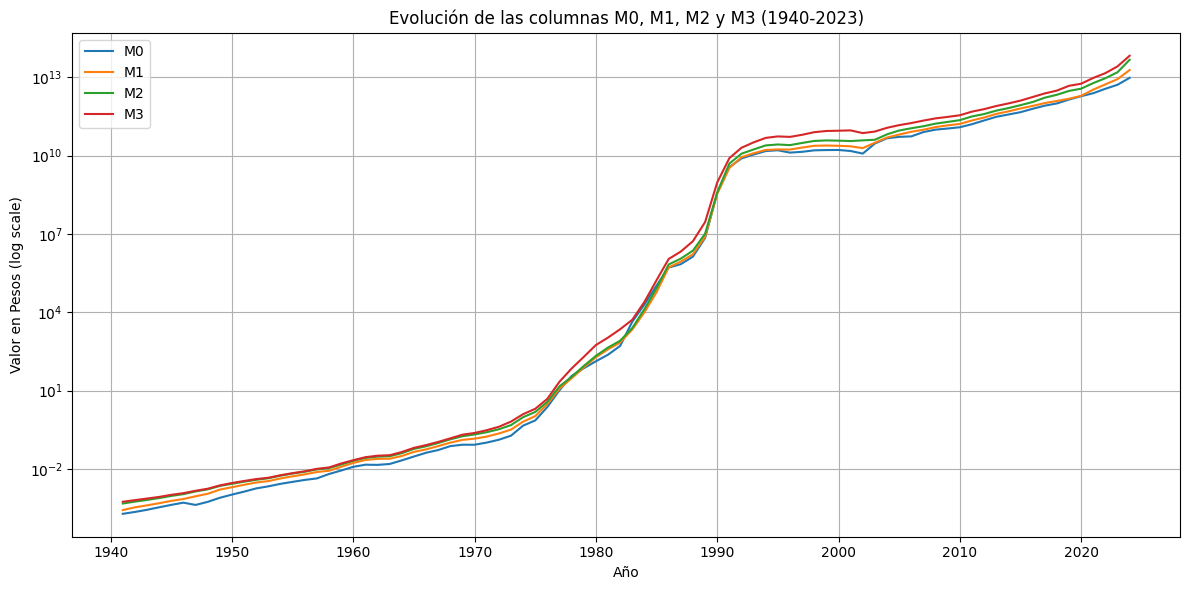

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# Configurar la figura y los ejes
plt.figure(figsize=(12, 6))
plt.title('Evolución de las columnas M0, M1, M2 y M3 (1940-2023)')
plt.xlabel('Año')
plt.ylabel('Valor en Pesos (log scale)')
plt.yscale('log')  # Escala logarítmica en el eje y

# Graficar las líneas temporales para M0, M1, M2 y M3
plt.plot(df_MA['Año'], df_MA['M0'], label='M0')
plt.plot(df_MA['Año'], df_MA['M1'], label='M1')
plt.plot(df_MA['Año'], df_MA['M2'], label='M2')
plt.plot(df_MA['Año'], df_MA['M3'], label='M3')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.tight_layout()
plt.show()